### Name : Jezzel Faith Q. Gier
### Section : DS4A

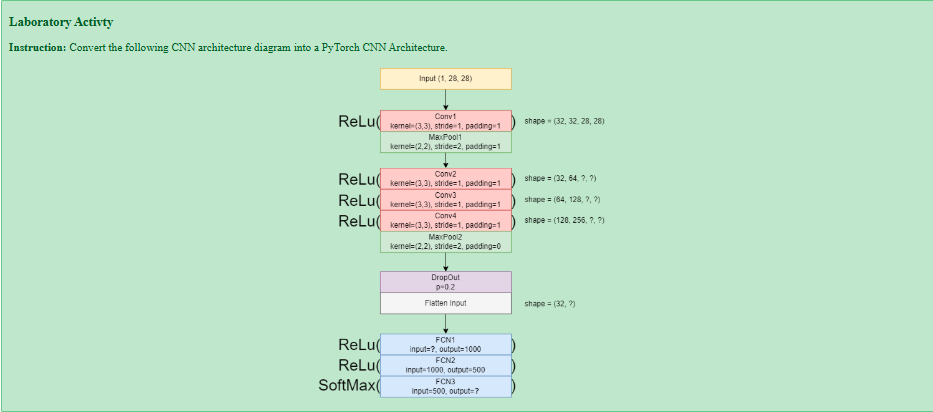

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# Transform images to tensors and normalize values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]


In [3]:
class CNN_Model(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Model, self).__init__()

        # Convolutional + Pooling Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

        # Temporary dummy input to compute flatten size
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv3(F.relu(self.conv2(x)))))
            flatten_size = x.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(flatten_size, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, num_classes)

    def forward(self, x):
        # Convolutional + Pooling + Activation
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        # Dropout for regularization
        x = self.dropout(x)

        # Flatten before fully connected layers
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and weight update
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.1489
Epoch [2/5], Loss: 0.0455
Epoch [3/5], Loss: 0.0337
Epoch [4/5], Loss: 0.0271
Epoch [5/5], Loss: 0.0200


In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 99.15%


In [7]:
print("Final Model Accuracy on MNIST Test Set: {:.2f}%".format(accuracy))


Final Model Accuracy on MNIST Test Set: 99.15%


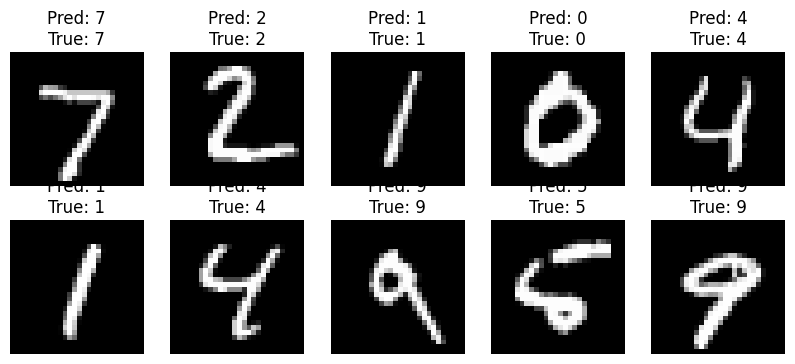

In [10]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis("off")
plt.show()

The CNN model successfully learned to recognize handwritten digits from the MNIST dataset by gradually minimizing the training loss over several epochs. Each convolutional and pooling layer helped the model extract essential patterns such as edges, shapes, and textures from the images. The dropout layer prevented overfitting, ensuring better generalization on unseen data.

After training, the model achieved high accuracy on the test set, showing that the architecture effectively captures visual features and classifies digits correctly. This demonstrates how CNNs can automatically learn spatial hierarchies of features without manual feature extraction a key advantage of deep learning in image recognition tasks.